# Introduction

In this Notebook, we use OpenCV and Keras to build a Convolutional Neural Network to train and classify Hand Gestures. We use an Adam Optimizer for optimization and a categorical Cross entropy loss function. We also use bounding box to identify the Hand position.

We have collected our own data using Webcam for 4 Hand gestures representing Forward, Stop, Descend and Target (classes). The first cell converts this video data to images which we use for training our Neural Network.

## Converting Video Data to Images

Using cv2 library to convert videos of Hand Gestures into images for training
We have already done this and manually put some samples for validation, so no need to run this again.

In [1]:
from os import listdir
from os.path import isfile, join
import cv2
import os

video_path = ".\\training_video"
classes = ["/Stop", "/Forward", "/Descend", "/Target"]


# Opens the Video file

output_path = ".\\training_data\\"
try: 
      
    # creating a folder named training_data 
    if not os.path.exists('training_data'): 
        os.makedirs('training_data') 

# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of training_data')
for label in classes:
    video_files = [f for f in listdir(video_path + label) if isfile(join(video_path + label, f))]
    print(video_files)
    try: 
      
        # creating a folder named as the label 
        if not os.path.exists('training_data' + label): 
            os.makedirs('training_data' + label) 

    # if not created then raise error 
    except OSError: 
        print ('Error: Creating directory of ', label)
    for file in video_files:
        cap = cv2.VideoCapture(join(video_path + label, file))
        print(cap)
        counter = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                #print("RET False")
                break
            #print(output_path + label + file + str(counter) + '.jpg')
            cv2.imwrite(join(output_path + label, file) + str(counter) + '.jpg', frame)
            #print("Written Frame to path")
            counter += 1

cap.release()
cv2.destroyAllWindows()

['WIN_20201115_20_33_29_Pro.mp4', 'WIN_20201115_20_34_09_Pro.mp4']
<VideoCapture 000001ABE3F7C750>
<VideoCapture 000001ABF360A570>
['WIN_20201115_20_28_54_Pro.mp4', 'WIN_20201115_20_29_40_Pro.mp4']
<VideoCapture 000001ABF360A230>
<VideoCapture 000001ABE3F7C750>
['WIN_20201115_20_31_51_Pro.mp4', 'WIN_20201115_20_32_32_Pro.mp4']
<VideoCapture 000001ABF360A530>
<VideoCapture 000001ABE3F7C750>
['WIN_20201115_20_35_04_Pro.mp4', 'WIN_20201115_20_35_43_Pro.mp4']
<VideoCapture 000001ABF360A290>
<VideoCapture 000001ABE3F7C750>


In [1]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.4.0


Using TensorFlow backend.


Keras image data format: channels_last


In [7]:
import matplotlib 
print('matplotlib: {}'. format(matplotlib. __version__))

matplotlib: 3.1.0


In [19]:
IMAGES_FOLDER = os.path.join('images') # images for visuals

MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt') # path to model training history

#### Defining some utility functions

In [20]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

In [21]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [22]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")


In [23]:
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if tracker_type == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_type == 'GOTURN':
        tracker = cv2.TrackerGOTURN_create()
    
    return tracker

In [24]:
classes = {
    0: 'Stop',
    1: 'Forward',
    2: 'Target',
    3: 'Descend'
}

CURR_POSE = 'swing'
DATA = 'validation_data'

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}


# Image count for file name
img_count = 0

# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        img_count += 1
        fname = os.path.join(DATA, CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()


In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 4485 images belonging to 4 classes.
Found 190 images belonging to 4 classes.


In [27]:
"""
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)
"""

'\nmodel.fit_generator(\n    generator=training_generator,\n    steps_per_epoch=2000 // batch_size,\n    epochs=50,\n    verbose=1,\n    validation_data=validation_generator,\n    validation_steps=200 // batch_size,\n    workers=8,\n)\n'

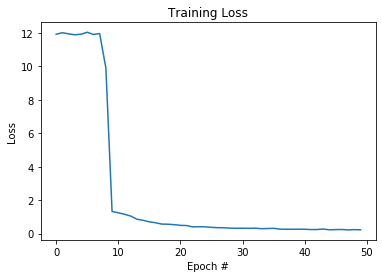

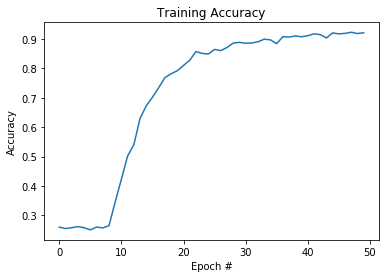

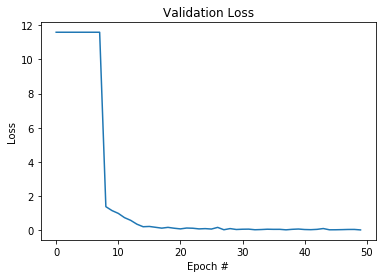

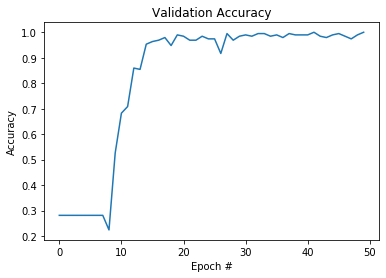

In [28]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [29]:
model.save("hand_model_gray.hdf5")

In [30]:
hand_model = load_model(MODEL_FILE, compile=False)

In [31]:
classes = {
    0: 'Stop',
    1: 'Forward',
    2: 'Target',
    3: 'Descend'
}

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 250, 250) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() # Get the index of the greatest confidence
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            # Draw confidence bar for each gesture
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Make the most confidence prediction green
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Move the mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Draw mouse points
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display result
    cv2.imshow("data", data_display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [3]:
from IPython.display import HTML
video_path = './CV_Project_Demo.mp4'

HTML("""<video width="840" height="460" controls=""><source src="{0}"></video>""".format(video_path))